In [1]:
import re
import os
import pathlib
import json
from typing import List, TypedDict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings

warnings.simplefilter(action="ignore")
sns.set_theme(style="darkgrid")

%matplotlib inline

In [2]:
experiment = "01_http_max_throughput"

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results" / experiment).resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()


In [3]:
"""
Clean the obtained results from the experiments
- Remove unnecessary columns
- Extract metadata from filenames
- Construct and clean data into a pandas.Series object
- Convert data measures in seconds to ms
"""

# Filter columns
required_cols = [
    "StartTime",
    "RequestedQPS",
    "ActualQPS",
    "DurationHistogram",
]


# fortio reports in seconds, convert to miliseconds
multiplier = 1000


# Regex to extract metadata
# 0 -> Full match
# 1 -> Protocol (http/grpc)
# 2 -> Mesh
# 3 -> Requested QPS
# 4 -> Transfer in bytes
# 5 -> Repetitionct dimensions from the filename
name_re = re.compile("^([a-z]+)_([a-z]+)_(\d+|MAX)_(\d+)_(\d+).*json$")

"""
Reads a fortio results JSON file, cleans the data and returns
it as a pandas.Series
"""
def clean_fortio_results(results_file: pathlib.Path) -> pd.Series :
    # Read the JSON file as pandas series
    s = pd.read_json(results_file, typ="series")

    # Filter unnecesary columns
    s = s[required_cols]

    # Extract metadata from filename and add it to the series
    matches = re.match(name_re, str(results_file.name))
    s["mesh"] = matches[2]
    s["payload"] = matches[4]

    # Extract nested columns in 'DurationHistogram'
    for key, val in s["DurationHistogram"].items():
        s[key] = val
    s = s.drop(["DurationHistogram", "Percentiles"])

    # Convert obervations from seconds to miliseconds
    s.loc[["Min", "Max", "Sum", "Avg"]] *= multiplier

    # Construct Histogram Bins, Counts and Percentiles
    data = s["Data"]

    s["counts"] = [x["Count"] for x in data]
    s["percentages"] = [x["Percent"] for x in data]

    # Bins (default pd.cut function makes them as categoricals of intervals)
    # https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html
    # https://pandas.pydata.org/docs/reference/api/pandas.Interval.html
    s["categories"]= pd.Categorical([pd.Interval(x["Start"] * multiplier , x["End"] * multiplier) for x in data])
    s["bins"] = [x.left for x in s["categories"]]
    s["bins"].append(s["categories"][-1].right)

    s = s.drop("Data")

    return s


In [4]:
"""
Parse all experiment results:
- Read the JSON files as a flat data structure
- Parse each result file as a individual data frame
- Concatenate all data frames where each row represents an observation
"""

series = []
for root, _, files in os.walk(results_dir, topdown=False):

    print(f"Parsing Experiment results:")
    print(f"Exp: {experiment}\nResults: {len(files)}")

    for file in files:
        # Skip resource usage files
        if not re.match("^(http|grpc).*\.json$", file):
            continue

        # Absolute path of the results file
        p = (pathlib.Path(root) / file).resolve()

        res = clean_fortio_results(p)
        series.append(res)

df = pd.DataFrame(series)

# Re-order
df = df[[
    "mesh",
    "RequestedQPS",
    "payload",
    "ActualQPS",
    "StartTime",
    "Count",
    "Min",
    "Max",
    "Sum",
    "Avg",
    "StdDev",
    "counts",
    "percentages",
    "categories",
    "bins",
]]

# Sort
df = df.sort_values(by=["mesh", "RequestedQPS", "payload"], ignore_index=True)
df.head()

Parsing Experiment results:
Exp: 01_http_max_throughput
Results: 15


,mesh,RequestedQPS,payload,ActualQPS,StartTime,Count,Min,Max,Sum,Avg,StdDev,counts,percentages,categories,bins
0,baseline,max,0,21652.916972,2022-06-26T14:31:58.681535434Z,19487682,0.046782,153.969754,2.879415e+07,1.477556,0.001485,"[175248, 552455, 552481, 574815, 618277, 71611...","[0.8992757578864431, 3.7341691023078063, 6.569...","[(0.046782, 0.1], (0.1, 0.2], (0.2, 0.30000000...","[0.046782, 0.1, 0.2, 0.30000000000000004, 0.4,..."
1,cilium,max,0,18009.233443,2022-06-27T11:36:24.504164386Z,16208409,0.056295,210.328264,2.879402e+07,1.776487,0.001718,"[49818, 391423, 400354, 456217, 429525, 436707...","[0.307358976442413, 2.722296802850915, 5.19233...","[(0.056295000000000005, 0.1], (0.1, 0.2], (0.2...","[0.056295000000000005, 0.1, 0.2, 0.30000000000..."
2,istio,max,0,4324.863928,2022-06-26T20:38:49.029226539Z,3892400,0.289687,970.993463,2.879299e+07,7.397233,0.010872,"[7, 9743, 162654, 201961, 133681, 61372, 40148...","[0.00017983763230900002, 0.250488130716267, 4....","[(0.28968700000000003, 0.30000000000000004], (...","[0.28968700000000003, 0.30000000000000004, 0.4..."
3,linkerd,max,0,9756.589185,2022-06-26T18:16:58.329471062Z,8780969,0.158514,390.944847,2.879118e+07,3.278816,0.003193,"[252, 32174, 63765, 58986, 53817, 48518, 48403...","[0.0028698427246460004, 0.369275873767462, 1.0...","[(0.15851400000000002, 0.2], (0.2, 0.300000000...","[0.15851400000000002, 0.2, 0.30000000000000004..."
4,traefik,max,0,565.807761,2022-06-27T09:12:42.078435711Z,509260,0.327453,363.693868,2.880107e+07,56.554737,0.048599,"[57, 594, 718, 645, 451, 443, 486, 479, 513, 1...","[0.01119271099242, 0.12783254133448502, 0.2688...","[(0.327453, 0.4], (0.4, 0.5], (0.5, 0.60000000...","[0.327453, 0.4, 0.5, 0.6000000000000001, 0.7, ..."


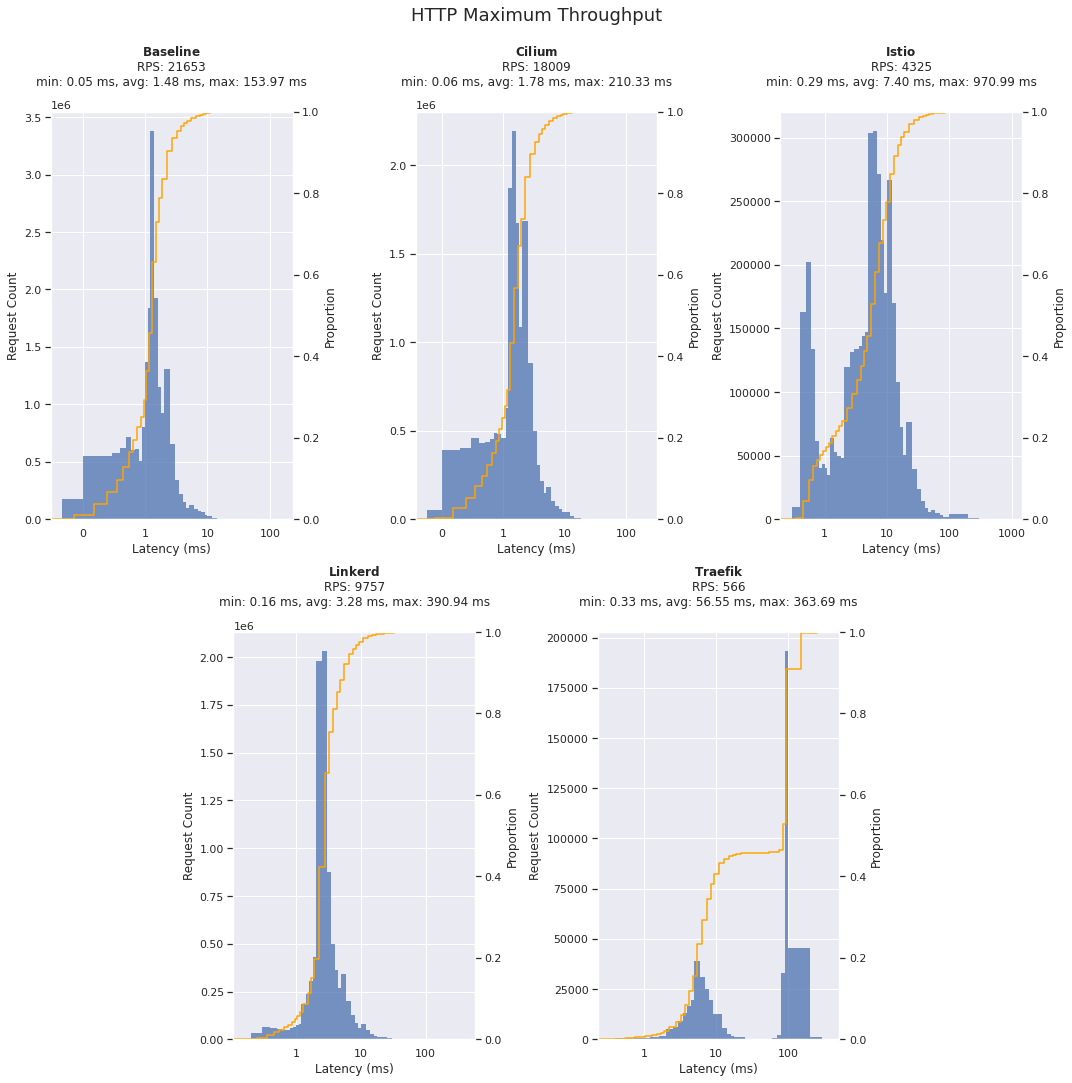

In [5]:
"""
Plotting of the results
- Create grid of subplots
- Plot figures on logarithmic scale (because of outliers)
"""

# Create grid of 
fig = plt.figure(figsize=(15, 15))

# Create a grid of subplots
gs = gridspec.GridSpec(nrows=2, ncols=6)

# Create subplots, each plot is 2 cols wide
axes=[
    # Row 0
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    fig.add_subplot(gs[0, 4:6]),
    # Row 1 (offset by 1)
    fig.add_subplot(gs[1, 1:3]),
    fig.add_subplot(gs[1, 3:5]),
]

# Set figure title
fig.suptitle("HTTP Maximum Throughput", fontsize=18, y=1)

# Plot each row as subplot
for i, row in df.iterrows():
    ax = axes[i]

    # Plot data
    binedges = np.array(row["bins"])
    weights = np.array(row["counts"])
    x = (binedges[1:] + binedges[:-1]) / 2.0

    sns.histplot(data=row, x=x, bins=binedges, weights=weights, color="b", ax=ax)

    # Labels
    plot_title = (
        f"$\\bf{row['mesh'].capitalize()}$\n"
        f"RPS: {row['ActualQPS']:.0f}\n"
        f"min: {row['Min']:.2f} ms, avg: {row['Avg']:.2f} ms, max: {row['Max']:.2f} ms"
    )
    ax.set_ylabel("Request Count")
    ax.set_xlabel("Latency (ms)")
    ax.set_title(plot_title, y=1.05)


    # Y AXIS
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


    # X AXIS
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


    # # Second plot with cumulative density
    ax2 = ax.twinx()
    ax2.set_alpha(0.5)
    ax2.grid(False)
    sns.ecdfplot(data=row, x=x, weights=weights, color="orange", ax=ax2)


fig.tight_layout()
fig.savefig(plot_dir / "exp_01-latency-results.pdf")
plt.show()